In [439]:
import pandas as pd
import numpy as np
import random
from itertools import combinations
import matplotlib.pyplot as plt
from tqdm import tqdm

%matplotlib inline

# Data Recreation

In [40]:
#First, load the individual user data (we will assign new user_id's and we need their political stance)
user_data = pd.read_csv('users_final.csv')
user_data['user_id'] = user_data['mturk']
user_data['user_key'] = user_data.index

user_data[['user_id','political_stand','user_key']].head()

,user_id,political_stand,user_key
0,5c34e423-8d6e-4a62-b4be-f8755748a2eb,strong Democrats,0
1,5c34ea5d-82ff-4f65-bee8-2ca4eb2848db,Republicans,1
2,5c34f29d-90b0-4c04-b78c-959b16f1c0d6,strong Democrats,2
3,5c34f45d-408d-4388-a655-f44a14991304,strong Democrats,3
4,5c34f905-a310-47cd-bf2b-324cf95e4adb,strong Democrats,4


In [41]:
#Load the answer data, and get extra columns used in later group by's
answer_data = pd.read_csv('answers_final.csv')

#Filter out Irrelevant Rows
answer_data = answer_data[answer_data['world_id'] != 0] #No World Z
answer_data = answer_data.iloc[:,:-2] #Remove false D & R columns

#Join in user_id's and political stance
answer_data = answer_data.join(user_data[['user_id','political_stand','user_key']].set_index('user_id'),on='user_id').reset_index()

#Get Order Grouped By Question & World
within_wq_order = []
q_dict = {q:0 for q in answer_data['question_id'].unique()}
counter_dict = {world:q_dict.copy() for world in sorted((answer_data['world_id'].unique()))}

for i in tqdm(range(len(answer_data))):
    data = answer_data.iloc[i].copy()

    world = data['world_id']
    question = data['question_id']    
    
    counter_dict[world][question] += 1
    within_wq_order += [counter_dict[world][question]]
    
answer_data['within_wq_order'] = within_wq_order

#Re-sort, Filter, & re-name the columns
answer_data = answer_data[['world_id','question_id','within_wq_order','user_key','index','user_political_stand','political_stand']]
answer_data.columns = ['world','question','wq_order','user_order','q_order','response','pol']

#Rename strings into values
answer_data['pol'] = answer_data['pol'].replace({'strong Democrats':-2, 'Democrats':-1,
                                                 'strong Republicans':+2, 'Republicans':+1})
answer_data['response'] = answer_data['response'].replace({'disagree':0, 'agree':1})

answer_data.head(10)

100%|██████████| 47298/47298 [00:10<00:00, 4375.39it/s]


,world,question,wq_order,user_order,q_order,response,pol
0,7,23,1,0,0,0.0,-2.0
1,7,18,1,0,1,0.0,-2.0
2,7,17,1,0,2,1.0,-2.0
3,7,6,1,0,3,1.0,-2.0
4,7,15,1,0,4,0.0,-2.0
5,7,12,1,0,5,0.0,-2.0
6,7,14,1,0,6,1.0,-2.0
7,7,20,1,0,7,1.0,-2.0
8,7,8,1,0,8,0.0,-2.0
9,7,9,1,0,9,0.0,-2.0


In [42]:
#Filter only on Q's 1-20
answer_data = answer_data[answer_data['question'] >= 1]
answer_data = answer_data[answer_data['question'] <= 20]

#Remove 'NaN's in response and politics
answer_data = answer_data.dropna()
 
#Sort by world and question order
answer_data = answer_data.sort_values('wq_order').sort_values(['world','question'])

In [43]:
#Generate a correct "conform", "D", "R", and "winner" columns

D_percent_list = [] #What is the current running % for Democrats
R_percent_list = [] #What is the current running % for Republican

winner_list = [] #Did D's or R's have the higher number (or was it equal?)
conform_col = [] #Did a user's (dis)agreement conform or rebel (or was the %'s equal at the time)

for w in tqdm(sorted(answer_data['world'].unique())):
    world_data = answer_data[answer_data['world'] == w]
    
    for q in sorted(world_data['question'].unique()):
        question_data = world_data[world_data['question'] == q]
        
        D, R = [], []
        
        for i,idx in enumerate(question_data.index):
            row = question_data.loc[idx]
            
            #Get the percent agreement
            D_percent = np.mean(D) if len(D) > 0 else 0.5
            R_percent = np.mean(R) if len(R) > 0 else 0.5

            #If Democrats & Republicans are "tied"
            if D_percent == R_percent:
                conform_col += ['equal']
                winner = 'equal'

            #If Democrats are "winning"
            elif D_percent > R_percent:
                winner = 'democrats'
                if (((row['pol'] < 0) & (row['response'] == 1)) or   #Democrat & Agree
                   ((row['pol'] > 0) & (row['response'] == 0))):     #Republican & Disagree
                    conform_col += ['conform']
                elif (((row['pol'] < 0) & (row['response'] == 0)) or #Democrat & Disagree
                     ((row['pol'] > 0) & (row['response'] == 1))):   #Republican & Agree
                    conform_col += ['rebel']

            #If Republicans are "winning"
            else:                    
                winner = 'republicans'
                if (((row['pol'] < 0) & (row['response'] == 0)) or  #Democrat & Disagree
                    ((row['pol'] > 0) & (row['response'] == 1))):    #Republican & Agree
                    conform_col += ['conform']
                elif (((row['pol'] < 0) & (row['response'] == 1)) or #Democrat & Agree
                     ((row['pol'] > 0) & (row['response'] == 0))):   #Republican & Disagree
                    conform_col += ['rebel']                   

            #Also add in D, R and Winner list
            D_percent_list += [np.mean(D) if len(D) > 0 else 0.5]
            R_percent_list += [np.mean(R) if len(R) > 0 else 0.5]
            winner_list += [winner]
            
            #Add to the running list of responses
            if row['pol'] < 0:
                D += [row['response']]
            else:
                R += [row['response']]
                


100%|██████████| 10/10 [00:11<00:00,  1.12s/it]


In [44]:
#Add in the columns

answer_data['conform'] = conform_col
answer_data['D%'] = D_percent_list
answer_data['R%'] = R_percent_list
answer_data['winner'] = winner_list

answer_data

,world,question,wq_order,user_order,q_order,response,pol,conform,D%,R%,winner
37,1,1,1,1,37,0.0,1.0,equal,0.500000,0.500000,equal
280,1,1,2,14,280,1.0,1.0,rebel,0.500000,0.000000,democrats
342,1,1,3,20,342,0.0,-1.0,equal,0.500000,0.500000,equal
669,1,1,4,36,669,0.0,2.0,rebel,0.000000,0.500000,republicans
783,1,1,5,41,783,0.0,1.0,rebel,0.000000,0.333333,republicans
1127,1,1,6,65,1127,1.0,-2.0,rebel,0.000000,0.250000,republicans
1199,1,1,7,69,1199,0.0,-2.0,rebel,0.500000,0.250000,democrats
1565,1,1,8,86,1565,0.0,2.0,conform,0.333333,0.250000,democrats
1737,1,1,9,94,1737,0.0,-1.0,rebel,0.333333,0.200000,democrats
1902,1,1,10,103,1902,1.0,2.0,rebel,0.250000,0.200000,democrats


In [45]:
answer_data.to_csv('answer_data_edited.csv')

# Figure 1

In [46]:
ind_data = answer_data[answer_data['world'] <=2]

ind_data = ind_data[ind_data['conform'] != 'equal'].groupby(['pol']).count()[['world']].join(
                ind_data[ind_data['conform'] == 'conform'].groupby(['pol']).count()[['question']])

ind_data.columns = ['total','conform']

ind_data['conf'] = ind_data['conform'] / ind_data['total'] - 0.5

ind_data.head()

,total,conform,conf
pol,,,
-2.0,2137,1013,-0.025971
-1.0,1806,851,-0.028793
1.0,2482,1331,0.036261
2.0,1970,1116,0.066497


In [47]:
inf_data = answer_data[answer_data['world'] > 2]

inf_data = inf_data[inf_data['conform'] != 'equal'].groupby(['pol']).count()[['world']].join(
                inf_data[inf_data['conform'] == 'conform'].groupby(['pol']).count()[['question']])

inf_data.columns = ['total','conform']

inf_data['conf'] = inf_data['conform'] / inf_data['total'] - 0.5

inf_data.head()

,total,conform,conf
pol,,,
-2.0,8159,5034,0.116987
-1.0,8222,4781,0.081489
1.0,10278,6349,0.117727
2.0,7028,4728,0.172738


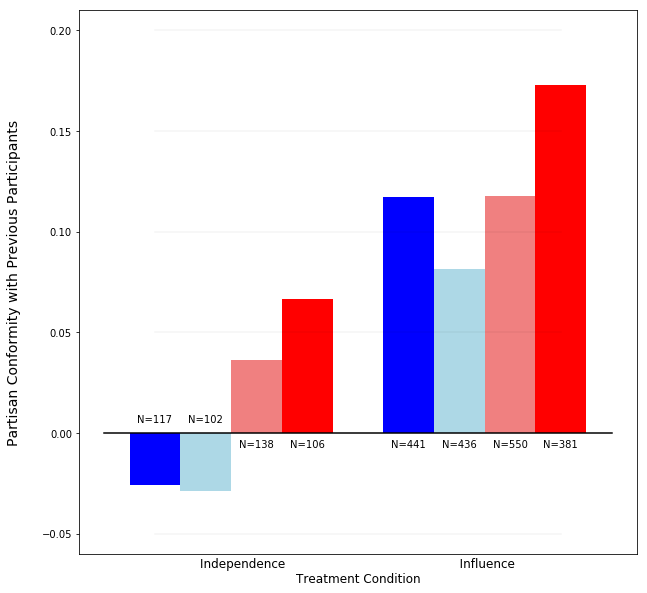

In [48]:
plt.figure(figsize =(10,10))

plt.plot(np.arange(-1,10),[0]*11,'k')
for i in np.arange(-.5,2.5,.5):
    plt.plot(np.arange(9),[i * 0.1]*9,'k',alpha=.04)
    
plt.bar(range(9), 
        [ind_data.loc[-2,'conf']] + [0]*4 + [inf_data.loc[-2,'conf']] + [0]*3,
        color='blue', width=1)
plt.bar(range(9), 
        [0]*1 + [ind_data.loc[-1,'conf']] + [0]*4 + [inf_data.loc[-1,'conf']] + [0]*2,
        color = 'lightblue', width=1)
plt.bar(range(9), 
        [0]*2 + [ind_data.loc[+1,'conf']] + [0]*4 + [inf_data.loc[+1,'conf']] + [0]*1,
        color = 'lightcoral', width=1)
plt.bar(range(9), 
        [0]*3 + [ind_data.loc[+2,'conf']] + [0]*4 + [inf_data.loc[+2,'conf']],
        color = 'red', width=1)

plt.text(0,.005,
         'N='+str(len(set(answer_data[(answer_data['world'] <=2) & (answer_data['pol'] == -2)]['user_order']))),
         horizontalalignment='center')
plt.text(1,.005,
         'N='+str(len(set(answer_data[(answer_data['world'] <=2) & (answer_data['pol'] == -1)]['user_order']))),
         horizontalalignment='center')
plt.text(2,-.007,
         'N='+str(len(set(answer_data[(answer_data['world'] <=2) & (answer_data['pol'] == +1)]['user_order']))),
         horizontalalignment='center')
plt.text(3,-.007,
         'N='+str(len(set(answer_data[(answer_data['world'] <=2) & (answer_data['pol'] == +2)]['user_order']))),
         horizontalalignment='center')
plt.text(5,-.007,
         'N='+str(len(set(answer_data[(answer_data['world'] >2) & (answer_data['pol'] == -2)]['user_order']))),
         horizontalalignment='center')
plt.text(6,-.007,
         'N='+str(len(set(answer_data[(answer_data['world'] >2) & (answer_data['pol'] == -1)]['user_order']))),
         horizontalalignment='center')
plt.text(7,-.007,
         'N='+str(len(set(answer_data[(answer_data['world'] >2) & (answer_data['pol'] == +1)]['user_order']))),
         horizontalalignment='center')
plt.text(8,-.007,
         'N='+str(len(set(answer_data[(answer_data['world'] >2) & (answer_data['pol'] == +2)]['user_order']))),
         horizontalalignment='center')

plt.ylim(-.06,0.21)
plt.xticks([-5])
plt.ylabel('Partisan Conformity with Previous Participants\n', size = 14)
plt.xlabel('Independence                                             Influence\nTreatment Condition', size = 12)


plt.show()


## Figure 1B

In [49]:
ind_str_data = answer_data[answer_data['world'] <=2].copy()

ind_str_data = ind_str_data[ind_str_data['response'] == 1].groupby(['pol','question']).count()[['world']].join(
               ind_str_data.groupby(['pol','question']).count()[['wq_order']])

ind_str_data.columns = ['agree','total']

ind_str_data['%agree'] = ind_str_data['agree'] / ind_str_data['total']

ind_str_data

agree  total    %agree
pol  question                        
-2.0 1            54    106  0.509434
     2            31    110  0.281818
     3            31    109  0.284404
     4            60    110  0.545455
     5            79    110  0.718182
     6            72    108  0.666667
     7            39    108  0.361111
     8            38    112  0.339286
     9            68    108  0.629630
     10           50    107  0.467290
     11           45    106  0.424528
     12           63    111  0.567568
     13           59    110  0.536364
     14           46    111  0.414414
     15           69    108  0.638889
     16           80    108  0.740741
     17           28    110  0.254545
     18           32    106  0.301887
     19           41    111  0.369369
     20           81    106  0.764151
-1.0 1            29     94  0.308511
     2            29     93  0.311828
     3            36     93  0.387097
     4            43     90  0.477778
     5            63     94  0.670213
     6            54     92  0.586957
     7            32     91  0.351648
     8            27     93  0.290323
     9            64     93  0.688172
     10           44     93  0.473118
...              ...    ...       ...
 1.0 11           67    132  0.507576
     12           70    128  0.546875
     13           69    129  0.534884
     14           51    128  0.398438
     15           81    130  0.623077
     16           78    126  0.619048
     17           28    127  0.220472
     18           44    130  0.338462
     19           49    129  0.379845
     20          103    126  0.817460
 2.0 1            50    102  0.490196
     2            25    101  0.247525
     3            16    102  0.156863
     4            41    101  0.405941
     5            66    100  0.660000
     6            67    102  0.656863
     7            23    102  0.225490
     8            19    100  0.190000
     9            58    102  0.568627
     10           42    101  0.415842
     11           51     99  0.515152
     12           52    100  0.520000
     13           42    100  0.420000
     14           32     99  0.323232
     15           58     99  0.585859
     16           49    101  0.485149
     17           21    100  0.210000
     18           29    101  0.287129
     19           39    100  0.390000
     20           88    100  0.880000

[80 rows x 3 columns]

In [50]:
inf_str_data = answer_data[answer_data['world'] > 2]

inf_str_data = inf_str_data[inf_str_data['response'] == 1].groupby(['pol','question']).count()[['world']].join(
               inf_str_data.groupby(['pol','question']).count()[['wq_order']])

inf_str_data.columns = ['agree','total']

inf_str_data['%agree'] = inf_str_data['agree'] / inf_str_data['total']

inf_str_data.head()

agree  total    %agree
pol  question                        
-2.0 1           197    423  0.465721
     2           163    418  0.389952
     3           183    422  0.433649
     4           235    419  0.560859
     5           299    417  0.717026

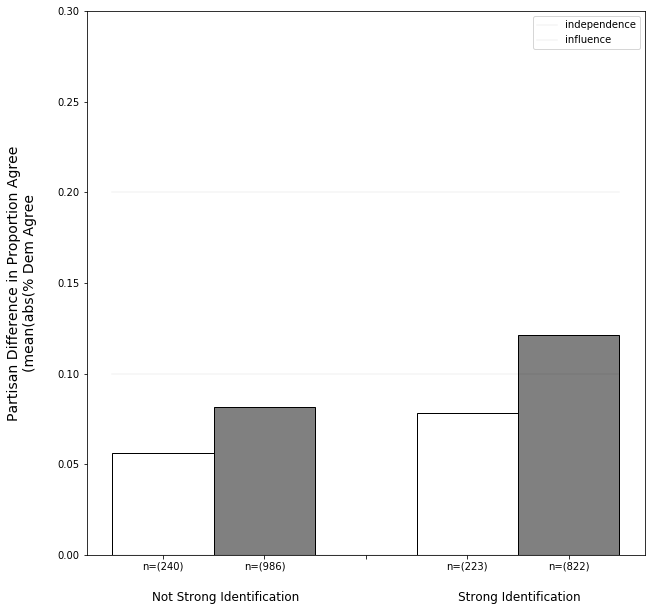

In [51]:
plt.figure(figsize =(10,10))

for i in range(0,3):
    plt.plot(np.arange(-0.5,5.,0.5),[i * 0.1]*11,'k',alpha=.04)
    
    
plt.bar(range(5), 
        [abs(ind_str_data.loc[-1,'%agree'] - ind_str_data.loc[+1,'%agree']).mean()] + 
        [0]*2 + 
        [abs(inf_str_data.loc[-1,'%agree'] - inf_str_data.loc[+1,'%agree']).mean()] + 
        [0],
        color='white', width=1, linewidth=1, edgecolor='k', 
        tick_label=['n=('+str(len(set(answer_data[(answer_data['world']<=2) & (answer_data['pol'].apply(lambda x: abs(x) == 1))]['user_order']))) + ')',
                    'n=('+str(len(set(answer_data[(answer_data['world']>2) & (answer_data['pol'].apply(lambda x: abs(x) == 1))]['user_order']))) + ')',
                    '',
                    'n=('+str(len(set(answer_data[(answer_data['world']<=2) & (answer_data['pol'].apply(lambda x: abs(x) == 2))]['user_order']))) + ')',
                    'n=('+str(len(set(answer_data[(answer_data['world']>2) & (answer_data['pol'].apply(lambda x: abs(x) == 2))]['user_order']))) + ')'])
plt.bar(range(5), 
        [0] + 
        [abs(ind_str_data.loc[-2,'%agree'] - ind_str_data.loc[+2,'%agree']).mean()] + 
        [0]*2 + 
        [abs(inf_str_data.loc[-2,'%agree'] - inf_str_data.loc[+2,'%agree']).mean()],
        color='grey', width=1, linewidth=1, edgecolor='k')
plt.ylim(0,0.3)
plt.ylabel('Partisan Difference in Proportion Agree\n(mean(abs(% Dem Agree\n', size = 14)
plt.xlabel('\nNot Strong Identification                                         Strong Identification', size = 12)

plt.legend(['independence','influence'])

plt.show()


# Figure 2

In [52]:
wq_data = answer_data.copy()
wq_data['pol_bin'] = wq_data['pol'].apply(lambda x: 1 if x > 0 else -1)

#Get proportions in each world
wq_data = wq_data.groupby(['world','question','pol_bin']).mean()[['response']]
wq_data = wq_data.to_dict()['response']

In [53]:
def check_disagreement(per1,per2):
    if ((per1 > 0.5) & (per2 < 0.5)) | ((per1 < 0.5) & (per2 > 0.5)):
        result = 1
    else:
        result = 0
    return result
        
#Reorganize the Data
wq_results_dict = {w:{q:{} for q in range(1,21)} for w in range(1,11)}

for world in range(1,11):
    for question in range(1,21):
        wq_results_dict[world][question]['D%'] = wq_data[(world,question,-1)]
        wq_results_dict[world][question]['R%'] = wq_data[(world,question,+1)]
        wq_results_dict[world][question]['delta_agree'] = wq_data[(world,question,-1)] - wq_data[(world,question,+1)]
        wq_results_dict[world][question]['disagree'] = check_disagreement(wq_data[(world,question,-1)],wq_data[(world,question,+1)])
        wq_results_dict[world][question]['significant'] = 0

In [54]:
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests

#Get p values (and add in bonferri correction)
wq_data_c2 = answer_data.copy()
wq_data_c2['pol_bin'] = wq_data_c2['pol'].apply(lambda x: 1 if x > 0 else -1)
 
p_list = []

#Get proportions in each world/question combination
for w in range(1,11):
    for q in range(1,21):
        
        #Filter on the specific question/world
        wq_data_c2filter = wq_data_c2[(wq_data_c2['world']==w) & (wq_data_c2['question'] == q)]
        
        #Run T-Test and get P-value
        p_value = ttest_ind(wq_data_c2filter[wq_data_c2filter['pol_bin'] == -1]['response'],
                            wq_data_c2filter[wq_data_c2filter['pol_bin'] == +1]['response'])[1]
        p_list += [p_value]        

#Run Bonferroni Correction
bonf_p = list(multipletests(p_list,method='bonferroni',alpha=.001)[1])

#If significant @ .001, assign each question/world combination a 1, else 0.
i = 0
for w in range(1,11):
    for q in range(1,21):
        if bonf_p[i] < .001:
            wq_results_dict[w][q]['sig'] = 1
        else:
            wq_results_dict[w][q]['sig'] = 0
        i += 1

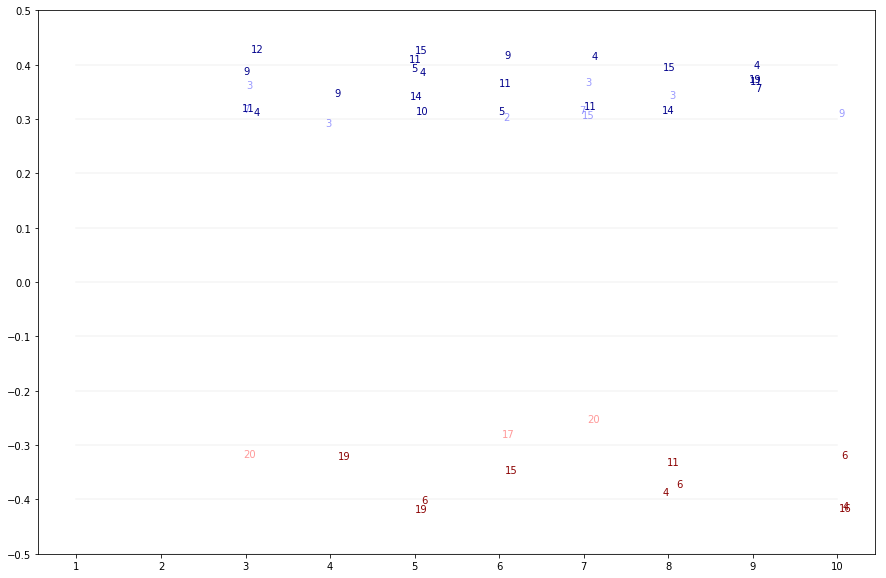

In [55]:
plt.figure(figsize=(15,10))

for i in np.arange(-.5,.6,.1):
    plt.plot(range(1,11),[i]*10, color='k', alpha=0.04)
for w in range(1,11):
    for q in range(1,21):
        if wq_results_dict[w][q]['sig'] == 1:
            if wq_results_dict[w][q]['delta_agree'] > 0:
                color = 'blue'
            else:
                color = 'red'
                
            if wq_results_dict[w][q]['disagree'] == 1:
                plt.text(x=w + random.uniform(-.1, .1),
                         y=wq_results_dict[w][q]['delta_agree'],
                         s=str(q),
                         color='dark'+color)
            else:
                plt.text(x=w + random.uniform(-.1, .1),
                         y=wq_results_dict[w][q]['delta_agree'],
                         s=str(q),
                         color=color,
                         alpha=0.4)

plt.ylim(-.5,.5)
plt.yticks(np.arange(-.5,.6,.1))
plt.xticks(range(1,11))

plt.show()

# Figure 3
#### --> Shows how the partisan alignment of issues was more unpredictable in the influence condition

In [482]:
# Independent Condition:
#   Randomly sort all 463 participants in the independence condition into two newly constituted worlds
#     with equal expected size and repeating the procedure 1000 times

# Collect bootstrap results
indep_mean_pairwise_diff = []
indep_change_sign_align  = []
indep_change_maj_one     = []
indep_change_maj_both    = []

# Compare partisan alignments in each of the 1000 pairs of randomly drawn worlds
#   Measured from –1 to 1 as the % of Ds who agree on an item minus the % of Rs who agree
indep_data        = answer_data[answer_data["world"]<=2]
indep_data["pol"] = indep_data["pol"].replace(-2,-1) #D
indep_data["pol"] = indep_data["pol"].replace(2,1) #R
indep_users       = len(indep_data.groupby("user_order"))
for i in range(1000):
    # randomly shuffle population and split into two world samples
    population = list(indep_data.groupby("user_order"))
    random.shuffle(population)
    world_a    = population[:indep_users//2]
    world_b    = population[indep_users//2:]
    # convert population and sample data back into dataframes
    population = [user[1] for user in population]
    population = pd.concat(population)
    world_a    = [user[1] for user in world_a]
    world_a    = pd.concat(world_a)
    world_b    = [user[1] for user in world_b]
    world_b    = pd.concat(world_b)

    # 1. mean pairwise difference in partisan alignment: between-world diff in between-party diff
    world_a_ans = world_a.groupby(["question", "pol"])["response"].mean()
    world_a_ans = world_a_ans.groupby("question").diff()
    world_a_diffs = []
    for i in range(0, len(world_a_ans), 2):
        world_a_diffs.append(world_a_ans.iloc[i])
    world_b_ans = world_b.groupby(["question", "pol"])["response"].mean()
    world_b_ans = world_b_ans.groupby("question").diff()
    world_b_diffs = []
    for i in range(0, len(world_b_ans), 2):
        world_b_diffs.append(world_b_ans.iloc[i])
    sample_diff = np.array(world_a_diffs)-np.array(world_b_diffs)
    mpd_result = np.mean(sample_diff)
    indep_mean_pairwise_diff.append(mpd_result)

    # 2. probability of between-world change in the party more likely to agree on the item
    #      (indicated by a change in the sign of partisan alignment between worlds)
    world_a_ans = world_a.groupby(["question", "pol"])["response"].mean()
    world_b_ans = world_b.groupby(["question", "pol"])["response"].mean()
    party_changes = 0
    for i in range(len(world_b_diffs)):
        world_a_major_rep = world_a_diffs[i]>0
        world_b_major_rep = world_b_diffs[i]>0
        if world_a_major_rep != world_b_major_rep:
            party_changes += 1
    csa_result = party_changes/len(world_a_ans)
    indep_change_sign_align.append(csa_result)

    # 3 & 4. change in the majority position in one party or both parties
    world_a_ans = world_a.groupby(["question", "pol"])["response"].mean()
    world_b_ans = world_b.groupby(["question", "pol"])["response"].mean()
    one_change = []
    two_change = []
    for i in range(0,len(world_a_ans),2):
        changes = 0
        world_a_dem_support = world_a_ans.iloc[i]   >=0.50
        world_b_dem_support = world_b_ans.iloc[i]   >=0.50
        world_a_rep_support = world_a_ans.iloc[i+1] >=0.50
        world_b_rep_support = world_b_ans.iloc[i+1] >=0.50
        if world_a_dem_support != world_b_dem_support:
            changes += 1
        if world_a_rep_support != world_b_rep_support:
            changes += 1
        if changes == 0:
            one_change.append(0)
            two_change.append(0)
        elif changes == 1:
            one_change.append(1)
            two_change.append(0)
        elif changes == 2:
            one_change.append(1)
            two_change.append(1)
        else:
            print("unexpected changes value:", changes)
            break
    one_change_prob = np.mean(one_change)
    two_change_prob = np.mean(two_change)
    indep_change_maj_one.append(one_change_prob)
    indep_change_maj_both.append(two_change_prob)

/Users/amruch/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/amruch/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [483]:
indep_mean_pairwise_diff_mean = np.mean(indep_mean_pairwise_diff)
indep_mean_pairwise_diff_std   = np.std(indep_mean_pairwise_diff)
indep_mean_pairwise_diff_se   = np.std(indep_mean_pairwise_diff)/np.sqrt(len(indep_mean_pairwise_diff))
print("indep_mean_pairwise_diff mean:{}, std:{}, se:{}:".format(indep_mean_pairwise_diff_mean,indep_mean_pairwise_diff_std,indep_mean_pairwise_diff_se))
indep_change_sign_align_mean  = np.mean(indep_change_sign_align)
indep_change_sign_align_std    = np.std(indep_change_sign_align)
indep_change_sign_align_se    = np.std(indep_change_sign_align)/np.sqrt(len(indep_change_sign_align))
print("indep_change_sign_align mean:{}, std:{}, se:{}".format(indep_change_sign_align_mean,indep_change_sign_align_std,indep_change_sign_align_se))
indep_change_maj_one_mean     = np.mean(indep_change_maj_one)
indep_change_maj_one_std       = np.std(indep_change_maj_one)
indep_change_maj_one_se       = np.std(indep_change_maj_one)/np.sqrt(len(indep_change_maj_one))
print("indep_change_maj_one mean:{}, std:{}, se:{}".format(indep_change_maj_one_mean,indep_change_maj_one_std,indep_change_maj_one_se))
indep_change_maj_both_mean    = np.mean(indep_change_maj_both)
indep_change_maj_both_std      = np.std(indep_change_maj_both)
indep_change_maj_both_se      = np.std(indep_change_maj_both)/np.sqrt(len(indep_change_maj_both))
print("indep_change_maj_both mean:{}, se:{}".format(indep_change_maj_both_mean,indep_change_maj_both_std,indep_change_maj_both_se))

indep_mean_pairwise_diff mean:-0.0004177069652075871, std:0.029373826240671006, se:0.0009288819451454166:
indep_change_sign_align mean:0.17282499999999998, std:0.04683368846247326, se:0.0014810112676816476
indep_change_maj_one mean:0.19365000000000002, std:0.055427227063961984, se:0.0017527628190944719
indep_change_maj_both mean:0.04025, se:0.0353897937264404


In [489]:
# Influence Condition:
#   Compare partisan alignments in each of the 28 pairs of eight influence worlds

# Collect bootstrap results
inf_mean_pairwise_diff = []
inf_change_sign_align  = []
inf_change_maj_one     = []
inf_change_maj_both    = []

# Compare partisan alignments in each pair of the 28 pairs of influence worlds
#   Measured from –1 to 1 as the % of Ds who agree on an item minus the % of Rs who agree
inf_data        = answer_data[answer_data["world"]>2]
inf_data["pol"] = inf_data["pol"].replace(-2,-1) #D
inf_data["pol"] = inf_data["pol"].replace(2,1) #R

# Sort populations by nC2 into 28 pairs
population = list(inf_data.groupby("world"))
population = list(combinations(population, 2))

for pop_pair in population:
    world_a = pop_pair[0][1]
    world_b = pop_pair[1][1]

    # 1. mean pairwise difference in partisan alignment: between-world diff in between-party diff
    world_a_ans = world_a.groupby(["question", "pol"])["response"].mean()
    world_a_ans = world_a_ans.groupby("question").diff()
    world_a_diffs = []
    for i in range(len(world_a_ans)):
        if i%2==1:
            world_a_diffs.append(world_a_ans.iloc[i])
    world_b_ans = world_b.groupby(["question", "pol"])["response"].mean()
    world_b_ans = world_b_ans.groupby("question").diff()
    world_b_diffs = []
    for i in range(len(world_b_ans)):
        if i%2==1:
            world_b_diffs.append(world_b_ans.iloc[i])
    sample_diff = np.array(world_a_diffs)-np.array(world_b_diffs)
    mpd_result = np.mean(sample_diff)
    inf_mean_pairwise_diff.append(mpd_result)

    # 2. probability of between-world change in the party more likely to agree on the item
    #      (indicated by a change in the sign of partisan alignment between worlds)
    world_a_ans = world_a.groupby(["question", "pol"])["response"].mean()
    world_b_ans = world_b.groupby(["question", "pol"])["response"].mean()
    party_changes = 0
    for i in range(len(world_a_diffs)):
        world_a_major_rep = world_a_diffs[i]>0
        world_b_major_rep = world_b_diffs[i]>0
        if world_a_major_rep != world_b_major_rep:
            party_changes += 1
    csa_result = party_changes/len(world_a_ans)
    inf_change_sign_align.append(csa_result)

    # 3 & 4. change in the majority position in one party or both parties
    world_a_ans = world_a.groupby(["question", "pol"])["response"].mean()
    world_b_ans = world_b.groupby(["question", "pol"])["response"].mean()
    one_change = []
    two_change = []
    for i in range(0,len(world_a_ans),2):
        changes = 0
        world_a_dem_support = world_a_ans.iloc[i]   >=0.50
        world_b_dem_support = world_b_ans.iloc[i]   >=0.50
        world_a_rep_support = world_a_ans.iloc[i+1] >=0.50
        world_b_rep_support = world_b_ans.iloc[i+1] >=0.50
        if world_a_dem_support != world_b_dem_support:
            changes += 1
        if world_a_rep_support != world_b_rep_support:
            changes += 1
        if changes == 0:
            one_change.append(0)
            two_change.append(0)
        elif changes == 1:
            one_change.append(1)
            two_change.append(0)
        elif changes == 2:
            one_change.append(1)
            two_change.append(1)
        else:
            print("unexpected changes value:", changes)
            break
    one_change_prob = np.mean(one_change)
    two_change_prob = np.mean(two_change)
    inf_change_maj_one.append(one_change_prob)
    inf_change_maj_both.append(two_change_prob)

/Users/amruch/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]
/Users/amruch/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [490]:
inf_mean_pairwise_diff_mean = np.mean(inf_mean_pairwise_diff)
inf_mean_pairwise_diff_std  = np.std(inf_mean_pairwise_diff)
inf_mean_pairwise_diff_se   = np.std(inf_mean_pairwise_diff)/np.sqrt(len(inf_mean_pairwise_diff))
print("inf_mean_pairwise_diff mean:{}, std:{}, se:{}:".format(inf_mean_pairwise_diff_mean,inf_mean_pairwise_diff_std,inf_mean_pairwise_diff_se))
inf_change_sign_align_mean  = np.mean(inf_change_sign_align)
inf_change_sign_align_std   = np.std(inf_change_sign_align)
inf_change_sign_align_se    = np.std(inf_change_sign_align)/np.sqrt(len(inf_change_sign_align))
print("inf_change_sign_align mean:{}, std:{}, se:{}".format(inf_change_sign_align_mean,inf_change_sign_align_std,inf_change_sign_align_se))
inf_change_maj_one_mean     = np.mean(inf_change_maj_one)
inf_change_maj_one_std      = np.std(inf_change_maj_one)
inf_change_maj_one_se       = np.std(inf_change_maj_one)/np.sqrt(len(inf_change_maj_one))
print("inf_change_maj_one mean:{}, std:{}, se:{}".format(inf_change_maj_one_mean,inf_change_maj_one_std,inf_change_maj_one_se))
inf_change_maj_both_mean    = np.mean(inf_change_maj_both)
inf_change_maj_both_std     = np.std(inf_change_maj_both)
inf_change_maj_both_se      = np.std(inf_change_maj_both)/np.sqrt(len(inf_change_maj_both))
print("inf_change_maj_both mean:{}, se:{}".format(inf_change_maj_both_mean,inf_change_maj_both_std,inf_change_maj_both_se))

inf_mean_pairwise_diff mean:-0.0386551728894496, std:0.08738399954787929, se:0.016514023669276373:
inf_change_sign_align mean:0.24285714285714285, std:0.06298282888767286, se:0.011902635864579802
inf_change_maj_one mean:0.42321428571428577, std:0.1004295620759919, se:0.018979403252299874
inf_change_maj_both mean:0.2017857142857143, se:0.08709820284469427


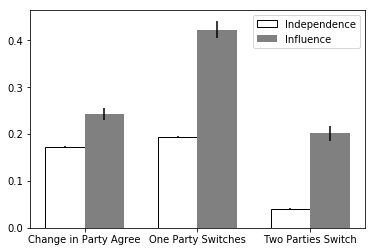

In [491]:
# Visualize results
fig, ax = plt.subplots()

N = 3
ind = np.arange(N) # the x locations for the groups
width = 0.35       # the width of the bars
p1 = ax.bar(
    ind,
    [indep_change_sign_align_mean, indep_change_maj_one_mean, indep_change_maj_both_mean],
    width,
    color='white',
    edgecolor="black",
    yerr=[indep_change_sign_align_se, indep_change_maj_one_se, indep_change_maj_both_se]
)
p2 = ax.bar(
    ind+width,
    [inf_change_sign_align_mean, inf_change_maj_one_mean, inf_change_maj_both_mean],
    width, color='gray',
    yerr=[inf_change_sign_align_se, inf_change_maj_one_se, inf_change_maj_both_se]
)

ax.set_xticks(ind+width / 2)
ax.set_xticklabels((
    'Change in Party Agree',
    'One Party Switches',
    'Two Parties Switch'))

ax.legend((p1[0], p2[0]), ('Independence', 'Influence'))
ax.autoscale_view()

plt.show()

# Figure 4a

In [56]:
ind_data = answer_data[answer_data['world']<=2].copy()
ind_data['pol_bin'] = ind_data['pol'].apply(lambda x: 1 if x > 0 else -1)
ind_data = ind_data.groupby(['question','pol_bin']).mean()['response']

x = [ind_data[q][-1]-ind_data[q][+1] for q in range(1,21)]

inf_data = answer_data[answer_data['world']>2].copy()
inf_data['pol_bin'] = inf_data['pol'].apply(lambda x: 1 if x > 0 else -1)
inf_data = inf_data.groupby(['question','pol_bin']).mean()['response']

y = [inf_data[q][-1]-inf_data[q][+1] for q in range(1,21)]

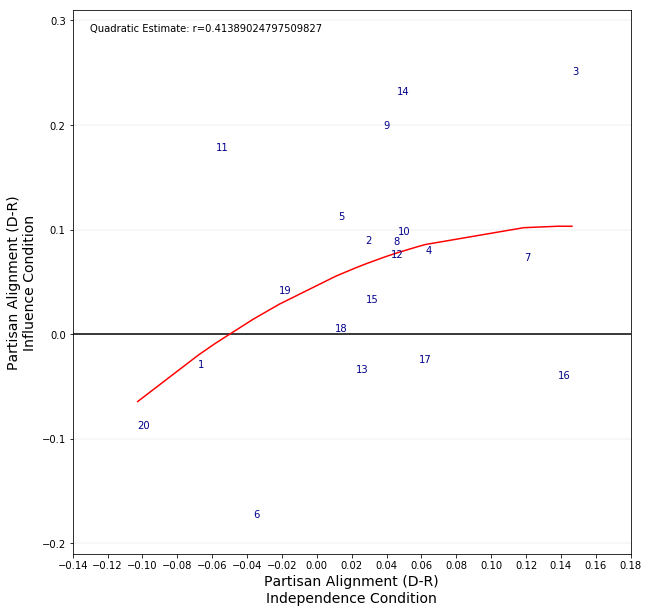

In [57]:
plt.figure(figsize=(10,10))

plt.plot(np.arange(-.14,.2,.02),[0]*17, color='k')
for i in np.arange(-.2,.4,.1):
    plt.plot(np.arange(-.14,.2,.02),[i]*17, color='k', alpha=0.04)

for i in range(1,21):
    plt.text(x[i-1],y[i-1],str(i),color='darkblue')
    
#Get Quadratic Function
a = np.polyfit(x,y,deg=2)
y_fit = [a[0]*v**2 + a[1]*v + a[2] for v in x]
b = pd.DataFrame([x,y_fit]).transpose().sort_values(0)
plt.plot(b[0],b[1],color='r')

#Get R^2
r = (np.sum([(y_fit[i] - np.mean(y))**2 for i in range(20)]) / 
     np.sum([(y[i]     - np.mean(y))**2 for i in range(20)]) ) ** 0.5
plt.text(-.13,0.29,'Quadratic Estimate: r='+str(r))
    
plt.xlim(-.14,.18)
plt.ylim(-.21,.31)
plt.xticks(np.arange(-.14,.2,.02))

plt.xlabel('Partisan Alignment (D-R)\nIndependence Condition', size=14)
plt.ylabel('Partisan Alignment (D-R)\nInfluence Condition', size=14)
    
plt.show()

# Figure 4b

In [58]:
#First, get last 100 in each question
wq_data = answer_data[answer_data['world'] > 2].copy()
wq_data['pol_bin'] = wq_data['pol'].apply(lambda x: 1 if x > 0 else -1)

last_100_list = {k:[] for k in range(1,21)}
first_10_list = {k:[] for k in range(1,21)}

for q in range(1,21):
    for w in range(1,11):
        wq_data_filter = wq_data[(wq_data['world']==w) & (wq_data['question'] == q)]
        last_100_list[q] += (list(wq_data_filter.index)[-100:])
        first_10_list[q] += list(wq_data_filter.index)[:10]
        

In [59]:
wq_data = answer_data[answer_data['world'] > 2].copy()
wq_data['pol_bin'] = wq_data['pol'].apply(lambda x: 1 if x > 0 else -1)

r_list = []

for i in range(10,110,10):
    
    #First, get indexes associated with first i and last 100
    first_i_list = {k:[] for k in range(1,21)}
    last_100_list = {k:[] for k in range(1,21)}

    for q in range(1,21):
        for w in range(1,11):
            wq_data_filter = wq_data[(wq_data['world']==w) & (wq_data['question'] == q)]
            first_i_list[q] += sorted(list(wq_data_filter.index)[:i])
            last_100_list[q] += sorted(list(wq_data_filter.index))[-100:]

    #Run correlation between First i users, and Last 100 users (with Quadratic Estimate)
    x, y = [], []
    for q in range(1,21): #Generate x_i and y_i values based the diff(%agree) for each question
        wq_data_Fi = wq_data.loc[first_i_list[q]]
        x += [wq_data_Fi[wq_data_Fi['pol_bin'] == -1]['response'].mean() - 
              wq_data_Fi[wq_data_Fi['pol_bin'] == +1]['response'].mean()]

        wq_data_L100 = wq_data.loc[last_100_list[q]]
        y += [wq_data_L100[wq_data_L100['pol_bin'] == -1]['response'].mean() - 
              wq_data_L100[wq_data_L100['pol_bin'] == +1]['response'].mean()]

    coefs = np.polyfit(x,y,deg=2)
    y_fit = [coefs[0]*v**2 + coefs[1]*v + coefs[2] for v in x]

    r = (np.sum([(y_fit[i] - np.mean(y))**2 for i in range(20)]) / 
         np.sum([(y[i]     - np.mean(y))**2 for i in range(20)]) ) ** 0.5
    
    r_list += [r]

Text(0,0.5,'Correlation Between First X and Last 100 Movers\ninPartisan Alignment\n')

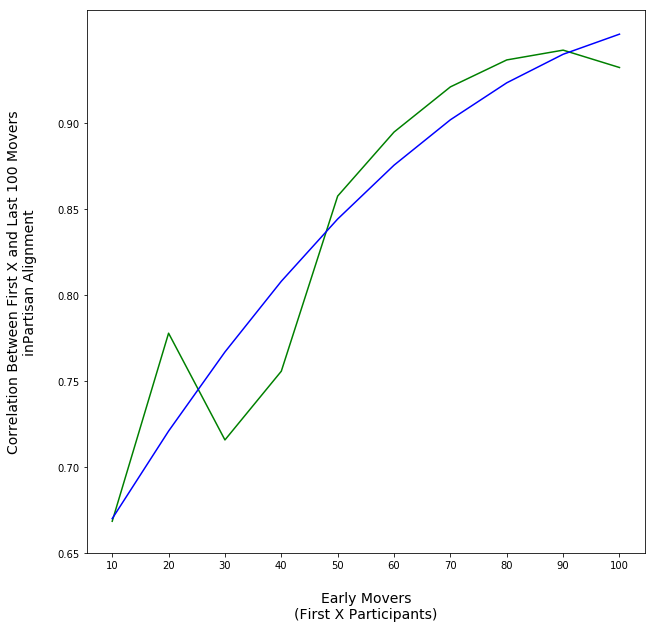

In [60]:
plt.figure(figsize=(10,10))

plt.plot(range(10,110,10),r_list,color='green')

coefs = np.polyfit(range(10,110,10),r_list,deg=2)
y_fit = [coefs[0]*v**2 + coefs[1]*v + coefs[2] for v in range(10,110,10)]
b = pd.DataFrame([range(10,110,10),y_fit]).transpose().sort_values(0)
plt.plot(b[0],b[1],color='b')

plt.xticks(range(10,110,10))
plt.yticks(np.arange(0.65,.95,.05))

plt.xlabel('\nEarly Movers\n(First X Participants)', size=14)
plt.ylabel('Correlation Between First X and Last 100 Movers\ninPartisan Alignment\n',size=14)
